### Import Libraries and Load Dataset

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pmdarima import auto_arima

# Read the data
df = pd.read_csv('../../Data/cleaned_dataset.csv')
oil_prices = df['Real Oil Prices']

In [30]:
# Check for null values and row count
df.info()
print(df.count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Columns: 123 entries, RPI to Real Oil Prices
dtypes: float64(123)
memory usage: 136.6 KB
RPI                142
W875RX1            142
DPCERA3M086SBEA    142
CMRMTSPLx          142
RETAILx            142
                  ... 
DTCOLNVHFNM        142
DTCTHFNM           142
INVEST             142
VIXCLSx            142
Real Oil Prices    142
Length: 123, dtype: int64


#### Visualize the Dataset

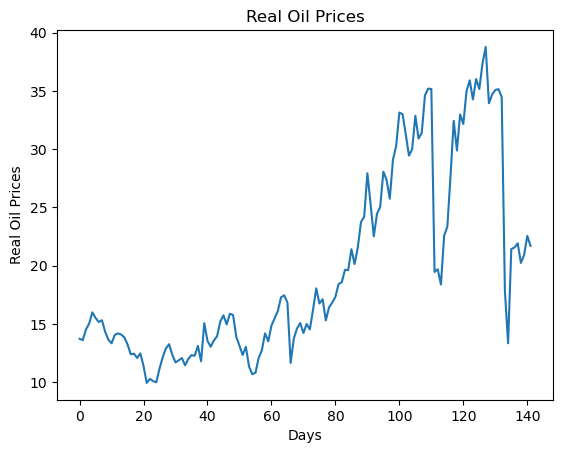

In [31]:
oil_prices.plot(title='Real Oil Prices')
plt.xlabel('Days')
plt.ylabel('Real Oil Prices')
plt.show()

### Test for Stationarity

In [32]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values ({key}): {value}')

test_stationarity(oil_prices)

ADF Statistic: -1.4102474268945113
p-value: 0.577353632901606
Critical Values (1%): -3.479742586699182
Critical Values (5%): -2.88319822181578
Critical Values (10%): -2.578319684499314


### Differencing to Achieve Stationarity

In [33]:
diff_oil_prices = oil_prices.diff().dropna()
test_stationarity(diff_oil_prices)

ADF Statistic: -5.741369645963949
p-value: 6.264329449602621e-07
Critical Values (1%): -3.479742586699182
Critical Values (5%): -2.88319822181578
Critical Values (10%): -2.578319684499314


### Model Selection using `auto_arima`

In [34]:
auto_model = auto_arima(oil_prices, seasonal=False, trace=True, suppress_warnings=True)
print(auto_model.summary())
best_order = auto_model.get_params()['order']

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=671.753, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=672.860, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=674.813, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=674.800, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=670.927, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.468 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  142
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -334.463
Date:                Wed, 08 Nov 2023   AIC                            670.927
Time:                        10:19:40   BIC                            673.875
Sample:                             0   HQIC                           672.125
                                - 142                          

### Train the ARIMA Model

In [35]:
#model = ARIMA(oil_prices, order=best_order) # with best order from auto_arima
model = ARIMA(oil_prices, order=(1, 1, 1)) # without auto_arima
results = model.fit()

## Split the Data into Training and Validation Sets

In [36]:
train_size = int(len(oil_prices) * 0.8)  # 80% of data for training
train, validation = oil_prices[:train_size], oil_prices[train_size:]

## Fit the ARIMA Model

In [37]:
auto_model = auto_arima(train, seasonal=False, trace=True, suppress_warnings=True)
best_order = auto_model.get_params()['order']
model = ARIMA(train, order=best_order)
results = model.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=478.978, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=478.674, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=480.537, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=480.517, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=476.752, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.378 seconds


## Forecast on the Validation Set

In [38]:
forecast = results.forecast(steps=len(validation))

## Evaluate the Model

In [39]:
mae = mean_absolute_error(validation, forecast)
mse = mean_squared_error(validation, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((validation - forecast) / validation)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 9.478102750143785
MSE: 130.0755488687976
RMSE: 11.405066806853768
MAPE: 29.86509305613786%


## Plot the Results

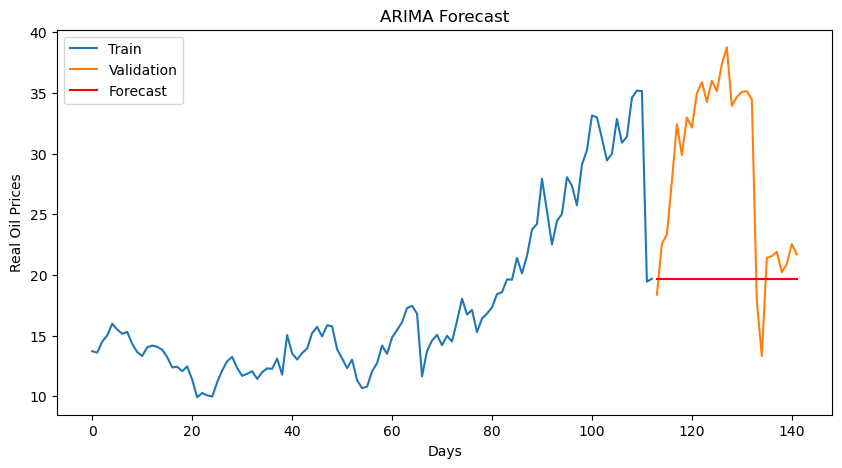

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(validation.index, forecast, color='red', label='Forecast')
plt.xlabel('Days')
plt.ylabel('Real Oil Prices')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

### Forecasting into the Future

In [41]:
future_steps = 30
forecast = results.forecast(steps=future_steps)  # predict the next n days

### Plot the Future Predictions

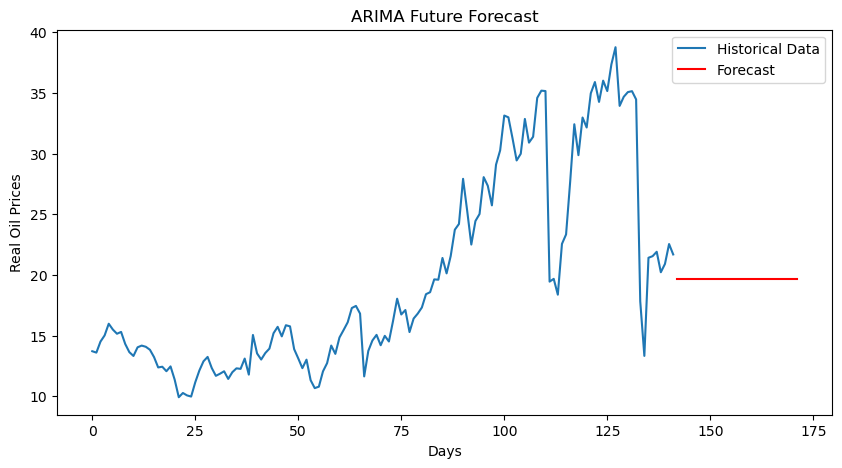

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(oil_prices, label='Historical Data')
plt.plot(np.arange(len(oil_prices), len(oil_prices) + future_steps), forecast, color='red', label='Forecast')
plt.xlabel('Days')
plt.ylabel('Real Oil Prices')
plt.title('ARIMA Future Forecast')
plt.legend()
plt.show()